## Importing packages & setting up connection

In [1]:
# Import Python packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import sys
import cachetools
from datetime import datetime
from datetime import date
import seaborn as sns
import math
from scipy import stats
import statsmodels.api as sm

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.snowpark.functions import col

# Clustering & Model
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, SVR
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, GradientBoostingClassifier, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier, XGBRegressor 
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Scalers
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# find the best combination of model hyperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

# Getting Password,Username, Account
import getpass

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\Ernest Toh\.conda\envs\pysnowpark\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Get account credentials from a json file
with open("account.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    #"role": "ACCOUNTADMIN",
    #"warehouse": "tasty_ds_wh",
    #"database": "frostbyte_tasty_bytes",
    #"schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## 1. Loading of Datasets <a id="part1"></a>

In [3]:
order_header_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.order_header")
customer_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_customer.customer_loyalty")
location_df = location_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.location")

In [4]:
order_header_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22477378    |97          |3713.0         |NULL           |NULL           |78881       |16:00:00            |23:00:00          |NULL             |2020-04-

In [5]:
customer_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"  |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|66             |Cannon        |Waters       |Toronto    |Canada         |M4C 3M7        |English               |Male         |NULL               |Married           |4                 |2019-10-08 

In [6]:
location_df.show()

----------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"PLACEKEY"           |"LOCATION"                     |"CITY"  |"REGION"  |"ISO_COUNTRY_CODE"  |"COUNTRY"  |
----------------------------------------------------------------------------------------------------------------------------
|13190          |zzy-22m@53g-bsm-9vf  |Sabine Weber                   |Munich  |Bayern    |DE                  |Germany    |
|13192          |zzy-22m@53g-ddj-ndv  |getAway LiveQuest              |Munich  |Bayern    |DE                  |Germany    |
|4883           |zzy-222@53g-brb-b8v  |Uptown                         |Munich  |Bayern    |DE                  |Germany    |
|4994           |zzy-222@53g-df2-vs5  |SV Neu Perlach                 |Munich  |Bayern    |DE                  |Germany    |
|4928           |zzy-222@53g-bs2-99f  |Borstei Museum                 |Munich  |Bayern    |DE                  |Germany    |


### Dropping of null values in customer id

In [7]:
order_header_df = order_header_df.na.drop(subset="CUSTOMER_ID")
order_header_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22477396    |97          |3713.0         |95165          |NULL           |78881       |16:00:00            |23:00:00          |NULL             |2020-04-

## 2. Data Preparation <a id="part2"></a>

### 2.1 Create dataframe <a id="part2-1"></a>
As mentioned earlier, our group will be focusing on the customers based in the US. Hence, we will need to filter the customer data to US. We are also doing basic data preparation to prepare our datasets so far for subsequent steps. 

In [8]:
# Filtering of customer dataset to only US
us_customer_df = customer_df.filter(F.col("COUNTRY")=="United States")
us_customer_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"    |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118            |Donald        |Faulkner     |San Mateo  |United States  |94010          |English               |Male         |NULL               |Single              |0                 |201

In [9]:
# After filtering of customer dataset to only US, we will be filtering and looking at the orders 
# based on these customers only

customer_US = us_customer_df.select(F.col("CUSTOMER_ID"))
order_header_df = order_header_df.join(customer_US, order_header_df.CUSTOMER_ID == customer_US.CUSTOMER_ID, lsuffix = "", rsuffix = "_US")
order_header_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|451449961   |17          |1789.0         |194230         |NULL           |200540458   |08:00:00 

### 2.2 Null Value Treatment for us_customer_df <a id="part2-2"></a>
After creating of the relevant data frames that we need, we will need to do null value treatment to further prepare our dataset for modelling. However, based on the data exploration done previously, we realised that the columns that contains null value will not be affecting the clustering of the model. Hence, we will drop the columns. 

In [10]:
# Drop irrelevant columns that will not be affecting the clustering of model and/or are all null
# us_customer_df = us_customer_df.drop(["FIRST_NAME", "LAST_NAME", "FAVOURITE_BRAND", "E_MAIL", "PHONE_NUMBER", "POSTAL_CODE"])

# Update categorical columns list
# cat_cols = [c.name for c in us_customer_df.schema.fields if type(c.datatype) == T.StringType]
# print(cat_cols)

['CITY', 'COUNTRY', 'PREFERRED_LANGUAGE', 'GENDER', 'MARITAL_STATUS', 'CHILDREN_COUNT']


In [11]:
# Missing value percentage
# for i in cat_cols:
    # print(i + ":", (us_customer_df.count() - us_customer_df.na.drop(subset = i).count())/us_customer_df.count())

CITY: 0.0
COUNTRY: 0.0
PREFERRED_LANGUAGE: 0.0
GENDER: 0.0
MARITAL_STATUS: 0.0
CHILDREN_COUNT: 0.0


### 2.3 Replacing values <a id="part2-3"></a>

In [12]:
# Update categorical columns list
# cat_cols = [c.name for c in us_customer_df.schema.fields if type(c.datatype) == T.StringType]

# Distinct values in each column
# dist_vals = us_customer_df.select([F.array_agg(col, is_distinct=True).as_(col) for col in cat_cols]).collect()[0].as_dict()
# dist_vals

{'CITY': '[\n  "San Mateo",\n  "New York City",\n  "Boston",\n  "Denver",\n  "Seattle"\n]',
 'COUNTRY': '[\n  "United States"\n]',
 'PREFERRED_LANGUAGE': '[\n  "English"\n]',
 'GENDER': '[\n  "Male",\n  "Undisclosed",\n  "Female"\n]',
 'MARITAL_STATUS': '[\n  "Single",\n  "Married",\n  "Undisclosed",\n  "Divorced/Seperated"\n]',
 'CHILDREN_COUNT': '[\n  "0",\n  "1",\n  "Undisclosed",\n  "2",\n  "4",\n  "5+",\n  "3"\n]'}

Based on the above code, we can drop "COUNTRY" and "PREFERRED_LANGAUGE" as they contain the same value. 

In [13]:
# Drop "COUNTRY" and "PREFERRED_LANGAUGE"
# us_customer_df = us_customer_df.drop(["COUNTRY", "PREFERRED_LANGUAGE"])

#### Replace 'Undisclosed' in CHILDREN_COUNT
Since most of the other values in CHILDREN_COUNT is an integer, let's replace the values 'Undisclosed' and '5+'. This would help in the encoding portion.

In [14]:
# us_customer_df = us_customer_df.withColumn("CHILDREN_COUNT", F.iff(F.col("CHILDREN_COUNT") == "Undisclosed", "0", F.col("CHILDREN_COUNT")))

We are replacing the "Undisclosed" values in the children count column with '0' because we don't have information about the number of children for those customers. Since the children count column represents the count of children a customer has, it doesn't make sense to keep the "Undisclosed" as a value. We are assuming that customers with "Undisclosed" values in the children count column have no children. We are not replacing or dropping them because it wouldn't make sense to encode those values, and dropping the rows would result in significant data loss.

In [15]:
# us_customer_df = us_customer_df.withColumn("CHILDREN_COUNT", F.iff(F.col("CHILDREN_COUNT")== "5+", "5", F.col("CHILDREN_COUNT")))

By replacing the "5+" values with '5', we are making a reasonable assumption to simplify the data and create a more consistent representation of the children count. This simplification allows for easier analysis and modeling while still capturing the general information about customers with a larger number of children.

Now that all the values in "CHILDREN_COUNT" is an integer, we will convert the column to integer.

In [16]:
# Convert "CHILDREN_COUNT" to integer
# us_customer_df = us_customer_df.withColumn("CHILDREN_COUNT", F.col("CHILDREN_COUNT").cast("int"))

### 2.4 Categorical encoding for us_customer_df <a id="part2-4"></a>
Categorical encoding is needed as machine learning models are not able to handle categorical variables. 

In [17]:
# Update categorical columns list
# cat_cols = [c.name for c in us_customer_df.schema.fields if type(c.datatype) == T.StringType]

# Distinct values in each column
# dist_vals = us_customer_df.select([F.array_agg(col, is_distinct=True).as_(col) for col in cat_cols]).collect()[0].as_dict()
# dist_vals

{'CITY': '[\n  "San Mateo",\n  "New York City",\n  "Boston",\n  "Denver",\n  "Seattle"\n]',
 'GENDER': '[\n  "Male",\n  "Undisclosed",\n  "Female"\n]',
 'MARITAL_STATUS': '[\n  "Single",\n  "Married",\n  "Undisclosed",\n  "Divorced/Seperated"\n]'}

We will use categorical encoding to ensure that all the data are in numerical format. “CITY”, “GENDER” and “MARITAL_STATUS” in the customer dataset will be encoded.

In [18]:
# city [Frequency Encoding]
# us_customer_df.group_by("CITY").agg(F.count("CUSTOMER_ID").alias("CID"))
# freq_enc = us_customer_df.groupBy("CITY").agg(F.count("CUSTOMER_ID").alias("city_frequency"))
    # join the encoded column back to the original DataFrame
# us_customer_df = us_customer_df.join(freq_enc, us_customer_df.CITY == freq_enc.CITY, lsuffix = "", rsuffix = "_FREQ_ENC")

Using frequency encoding for "CITY" can help to retain valuable information such as the distribution of each city in the dataset.

Label encoding will be applied to “GENDER” and “MARITAL_STATUS”. 

In [19]:
# Gender [Label Encoding]
#  Male -> 0
#  Female -> 1
#  Undisclosed -> 2

# us_customer_df = us_customer_df.withColumn("Gender", F.when(us_customer_df["GENDER"] == "Male", "0")
                                             # .when(us_customer_df["GENDER"] == "Female", "1").otherwise("2"))

In [20]:
# Marital status [Label Encoding]
#  Married -> 0 
#  Single -> 1
#  Divorced/seperated -> 2 
#  Undisclosed -> 3

# us_customer_df = us_customer_df.withColumn(
    # "MARITAL_STATUS",
    # F.when(us_customer_df["MARITAL_STATUS"] == "Married", "0")
    # .when(us_customer_df["MARITAL_STATUS"] == "Single", "1")
    # .when(us_customer_df["MARITAL_STATUS"] == "Divorced/Seperated", "2")
    # .otherwise("3")
# )

In [21]:
order_header_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|451449961   |17          |1789.0         |194230         |NULL           |200540458   |08:00:00 

Start

In [22]:
# getting last order date
lastest_transaction = order_header_df.agg(F.max("ORDER_TS").alias("LAST_ORDER_TS")).collect()[0][0]
order_header_df = order_header_df.withColumn("LAST_DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction, lastest_transaction))

In [23]:
# getting date for two weeks before last transaction date provided
order_header_df = order_header_df.withColumn("two_weeks_before", F.date_sub("LAST_DATE", 14))

In [24]:
order_header_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |"LAST_DATE"          |"TWO_WEEKS_BEFORE"   |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
# Get data till 2 weeks before last transaction date provided
order_df1 = order_header_df.filter(F.col("ORDER_TS")<=F.col("TWO_WEEKS_BEFORE"))
order_df1.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |"LAST_DATE"          |"TWO_WEEKS_BEFORE"   |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
# Ensure timeframe is correct
order_df1.agg(F.min('ORDER_TS')).show()
order_df1.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2019-01-01 17:19:08  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-10-18 22:56:45  |
-----------------------



In [27]:
# Get last 2 weeks before last transaction date provided
order_df2 = order_header_df.filter(F.col("ORDER_TS")>F.col("TWO_WEEKS_BEFORE"))
order_df2.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |"LAST_DATE"          |"TWO_WEEKS_BEFORE"   |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
# Ensure timeframe is correct
order_df2.agg(F.min('ORDER_TS')).show()
order_df2.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2022-10-19 08:00:15  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-11-01 22:58:56  |
-----------------------



In [29]:
# getting the latest purchase date for each customer in df1
customer_last_order_timestamp_df1 = order_df1.groupBy("CUSTOMER_ID").agg(F.max("ORDER_TS").alias("LAST_ORDER_TS"))
customer_last_order_timestamp_df1.show()

---------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |
---------------------------------------
|32738          |2022-10-16 11:31:08  |
|47471          |2022-10-13 18:30:29  |
|187244         |2022-10-12 20:59:10  |
|20772          |2022-10-16 20:58:09  |
|182214         |2022-10-09 15:47:55  |
|16019          |2022-10-15 15:39:14  |
|136529         |2022-09-17 12:13:34  |
|190059         |2022-10-06 18:08:05  |
|149166         |2022-10-15 09:43:44  |
|71370          |2022-10-06 19:28:07  |
---------------------------------------



In [30]:
# getting last order date
lastest_transaction_df1 = order_df1.agg(F.max("ORDER_TS").alias("LAST_ORDER_TS")).collect()[0][0]
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.withColumn("LAST_TRANS", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction_df1, lastest_transaction_df1))
customer_last_order_timestamp_df1.show()

-------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |
-------------------------------------------------------------
|79393          |2022-10-11 12:29:02  |2022-10-18 22:56:45  |
|97467          |2022-10-10 19:35:25  |2022-10-18 22:56:45  |
|133167         |2022-10-14 09:12:50  |2022-10-18 22:56:45  |
|136558         |2022-10-06 09:52:47  |2022-10-18 22:56:45  |
|116361         |2022-10-11 08:38:17  |2022-10-18 22:56:45  |
|184615         |2022-10-15 16:26:00  |2022-10-18 22:56:45  |
|173763         |2022-10-15 13:43:25  |2022-10-18 22:56:45  |
|69193          |2022-10-04 20:49:39  |2022-10-18 22:56:45  |
|62668          |2022-10-18 17:12:18  |2022-10-18 22:56:45  |
|100201         |2022-10-11 20:12:32  |2022-10-18 22:56:45  |
-------------------------------------------------------------



In [31]:
# getting the date diff from customer last order to the date 2 weeks before the latest provided transaction date in df1
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.withColumn("days_df1", F.datediff("day", customer_last_order_timestamp_df1["LAST_ORDER_TS"], customer_last_order_timestamp_df1["LAST_TRANS"]))
customer_last_order_timestamp_df1.show()

--------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
--------------------------------------------------------------------------
|124359         |2022-10-15 21:14:26  |2022-10-18 22:56:45  |3           |
|26903          |2022-09-27 19:40:31  |2022-10-18 22:56:45  |21          |
|184652         |2022-09-19 14:15:24  |2022-10-18 22:56:45  |29          |
|168228         |2022-10-08 13:29:44  |2022-10-18 22:56:45  |10          |
|188230         |2022-10-18 22:00:13  |2022-10-18 22:56:45  |0           |
|118953         |2022-10-15 19:01:22  |2022-10-18 22:56:45  |3           |
|112770         |2022-10-10 14:32:51  |2022-10-18 22:56:45  |8           |
|165951         |2022-09-22 11:03:39  |2022-10-18 22:56:45  |26          |
|187488         |2022-10-11 09:32:07  |2022-10-18 22:56:45  |7           |
|12820          |2022-10-13 12:59:55  |2022-10-18 22:56:45  |5           |
-------------------------

In [32]:
# getting the earliest purchase date for each customer in df2
customer_first_order_timestamp_df2 = order_df2.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp_df2 = customer_first_order_timestamp_df2.sort(col("FIRST_ORDER_TS"))
customer_first_order_timestamp_df2.show()

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|184287         |2022-10-19 08:00:15  |
|42060          |2022-10-19 08:00:46  |
|196281         |2022-10-19 08:00:59  |
|127806         |2022-10-19 08:01:29  |
|170016         |2022-10-19 08:01:47  |
|64450          |2022-10-19 08:01:53  |
|191049         |2022-10-19 08:01:59  |
|118969         |2022-10-19 08:02:19  |
|192268         |2022-10-19 08:04:20  |
|95980          |2022-10-19 08:04:33  |
---------------------------------------



In [33]:
# getting first order date
earliest_transaction_df2 = order_df2.agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS")).collect()[0][0]
customer_first_order_timestamp_df2 = customer_first_order_timestamp_df2.withColumn("FIRST_TRANS", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), earliest_transaction_df2, earliest_transaction_df2))
customer_first_order_timestamp_df2.show()

-------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |"FIRST_TRANS"        |
-------------------------------------------------------------
|184287         |2022-10-19 08:00:15  |2022-10-19 08:00:15  |
|42060          |2022-10-19 08:00:46  |2022-10-19 08:00:15  |
|196281         |2022-10-19 08:00:59  |2022-10-19 08:00:15  |
|127806         |2022-10-19 08:01:29  |2022-10-19 08:00:15  |
|170016         |2022-10-19 08:01:47  |2022-10-19 08:00:15  |
|64450          |2022-10-19 08:01:53  |2022-10-19 08:00:15  |
|191049         |2022-10-19 08:01:59  |2022-10-19 08:00:15  |
|118969         |2022-10-19 08:02:19  |2022-10-19 08:00:15  |
|192268         |2022-10-19 08:04:20  |2022-10-19 08:00:15  |
|95980          |2022-10-19 08:04:33  |2022-10-19 08:00:15  |
-------------------------------------------------------------



In [34]:
# getting the date diff from customer last order to the date 2 weeks before the latest provided transaction date in df1
customer_first_order_timestamp_df2 = customer_first_order_timestamp_df2.withColumn("days_df2", F.datediff("day", customer_first_order_timestamp_df2["FIRST_TRANS"], customer_first_order_timestamp_df2["FIRST_ORDER_TS"]))
customer_first_order_timestamp_df2.show()

--------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |"FIRST_TRANS"        |"DAYS_DF2"  |
--------------------------------------------------------------------------
|38285          |2022-10-20 09:11:32  |2022-10-19 08:00:15  |1           |
|104539         |2022-10-20 09:11:39  |2022-10-19 08:00:15  |1           |
|59591          |2022-10-20 09:11:52  |2022-10-19 08:00:15  |1           |
|168239         |2022-10-20 09:11:52  |2022-10-19 08:00:15  |1           |
|57049          |2022-10-20 09:12:10  |2022-10-19 08:00:15  |1           |
|101818         |2022-10-20 09:12:13  |2022-10-19 08:00:15  |1           |
|36932          |2022-10-20 09:12:31  |2022-10-19 08:00:15  |1           |
|102403         |2022-10-20 09:12:32  |2022-10-19 08:00:15  |1           |
|189249         |2022-10-20 09:12:41  |2022-10-19 08:00:15  |1           |
|57064          |2022-10-20 09:12:53  |2022-10-19 08:00:15  |1           |
-------------------------

In [35]:
# merge the first dataframe with cust df
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.join(us_customer_df, us_customer_df.CUSTOMER_ID == customer_last_order_timestamp_df1.CUSTOMER_ID, lsuffix="", rsuffix="_ID")
customer_last_order_timestamp_df1.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"CUSTOMER_ID_ID"  |"CITY"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"CHILDREN_COUNT"  |"CITY_FREQ_ENC"  |"CITY_FREQUENCY"  |"GENDER"  |"MARITAL_STATUS"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|198908         |2022-09-01 19:15:34  |2022-10-18 22:56:45  |47          |198908            |Denver  |2020-04-02      |1963-11-06       |0                 |Denver           |9122              |1         |1                 |
|198984         |2022-10-05 10:48:42  |2022-10-18 22:56:45  |13          |198984            |Denver  |20

### 2.5 Calculating customer's age <a id="part2-5"></a>
“BIRTHDAY_DATE” will be replaced by “AGE” instead, with the last order transaction date recorded based on all the customers as the current date. 

In [36]:
# Calculating of the age of each customer based on the last order transaction date recorded based on all customers as current date 
# customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.withColumn("AGE", F.datediff("year", F.col("BIRTHDAY_DATE"), F.col("LAST_TRANS")))
# customer_last_order_timestamp_df1.show()

In [37]:
# drop unnecessary columns 
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.drop("CUSTOMER_ID_ID", "CITY", "BIRTHDAY_DATE", "CHILDREN_COUNT", "CITY_FREQ_ENC", "CITY_FREQUENCY", "GENDER", "MARITAL_STATUS")
customer_last_order_timestamp_df1.show()

-------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"SIGN_UP_DATE"  |
-------------------------------------------------------------------------------------------
|174436         |2022-10-08 18:09:44  |2022-10-18 22:56:45  |10          |2021-09-28      |
|81065          |2022-10-12 11:00:05  |2022-10-18 22:56:45  |6           |2021-04-26      |
|96339          |2022-10-14 12:47:52  |2022-10-18 22:56:45  |4           |2020-01-01      |
|192057         |2022-10-18 09:25:54  |2022-10-18 22:56:45  |0           |2022-02-14      |
|194053         |2022-10-18 13:25:07  |2022-10-18 22:56:45  |0           |2021-11-07      |
|85110          |2022-10-12 21:29:22  |2022-10-18 22:56:45  |6           |2020-03-09      |
|88385          |2022-10-18 20:05:44  |2022-10-18 22:56:45  |0           |2020-02-23      |
|100094         |2022-10-17 19:58:59  |2022-10-18 22:56:45  |1           |2021-1

### 2.6 Calculating RFM <a id="part2-6"></a>

#### 2.6.1 Calculation of Recency <a id="part2-6-1"></a>
To calculate the recency of orders for each customer, we will take the last order timestamp of the customer minus the current date identified. 

In [38]:
# Creating a new dataframe and adding column with current date as the latest 
# transaction timestamp identified previously 

# Calculate recency days
customer_recency = customer_last_order_timestamp_df1.with_column("RECENCY_DAYS", F.datediff('day', customer_last_order_timestamp_df1["LAST_ORDER_TS"], customer_last_order_timestamp_df1["LAST_TRANS"]))
customer_recency.show()

------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"SIGN_UP_DATE"  |"RECENCY_DAYS"  |
------------------------------------------------------------------------------------------------------------
|174436         |2022-10-08 18:09:44  |2022-10-18 22:56:45  |10          |2021-09-28      |10              |
|81065          |2022-10-12 11:00:05  |2022-10-18 22:56:45  |6           |2021-04-26      |6               |
|96339          |2022-10-14 12:47:52  |2022-10-18 22:56:45  |4           |2020-01-01      |4               |
|192057         |2022-10-18 09:25:54  |2022-10-18 22:56:45  |0           |2022-02-14      |0               |
|194053         |2022-10-18 13:25:07  |2022-10-18 22:56:45  |0           |2021-11-07      |0               |
|85110          |2022-10-12 21:29:22  |2022-10-18 22:56:45  |6           |2020-03-09      |6               |
|88385          |20

In [39]:
# Calculating the number of days since a customer bought from Tasty Bytes based 
# on the date difference between the current date and last order timestamp and 
# adding it into the customer_recency data frame

temp_customer_recency = customer_recency.select('CUSTOMER_ID','RECENCY_DAYS')

# Joining customer_recency and customer_df to make a new data frame which will be used for clustering
customer_last_order_timestamp_df1 = temp_customer_recency.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==temp_customer_recency.CUSTOMER_ID, lsuffix="", rsuffix="_RECENCY")

In [40]:
customer_last_order_timestamp_df1.show()

------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"SIGN_UP_DATE"  |
------------------------------------------------------------------------------------------------------------------------------------
|12261          |19              |12261                  |2022-09-29 17:43:31  |2022-10-18 22:56:45  |19          |2021-12-28      |
|12416          |9               |12416                  |2022-10-09 09:03:44  |2022-10-18 22:56:45  |9           |2020-10-09      |
|12590          |11              |12590                  |2022-10-07 16:39:46  |2022-10-18 22:56:45  |11          |2021-10-14      |
|12784          |21              |12784                  |2022-09-27 13:38:08  |2022-10-18 22:56:45  |21          |2020-06-19      |
|13074          |12              |13074                  |2022-10-06 

#### 2.6.2 Calculation of Frequency <a id="part2-6-2"></a>
To calculate the frequency of orders for each customer, we will be calculating the total order by customers divided by the duration between their first order and the current date identified.

In [41]:
order_df1.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |"LAST_DATE"          |"TWO_WEEKS_BEFORE"   |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
# Obtain the time stamp for each customer’s first order
customer_first_order_timestamp = order_df1.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp.show(n=5)

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|79019          |2019-05-12 19:54:40  |
|45155          |2019-05-14 21:28:35  |
|64236          |2019-06-23 13:58:59  |
|97152          |2019-11-25 08:07:24  |
|94272          |2019-08-31 15:38:36  |
---------------------------------------



In [43]:
# Calculating the total number of orders for each customer
total_order_by_cust = order_df1.group_by("CUSTOMER_ID").agg(F.count("ORDER_ID").alias("TOTAL_ORDER"))
total_order_by_cust.show(n=5)

---------------------------------
|"CUSTOMER_ID"  |"TOTAL_ORDER"  |
---------------------------------
|53609          |47             |
|158572         |73             |
|147590         |54             |
|14861          |60             |
|18975          |45             |
---------------------------------



In [44]:
# Joining the total number of orders, first order timestamp tables with the customer data
customer_freq = customer_df.join(customer_first_order_timestamp, customer_df.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")
customer_freq = customer_freq.join(total_order_by_cust, customer_freq.CUSTOMER_ID==total_order_by_cust.CUSTOMER_ID, lsuffix="", rsuffix="_NUM_ORDER")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “CUSTOMER_FREQUENCY” to calculate the frequency
customer_freq = customer_freq.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction_df1, lastest_transaction_df1))
customer_freq = customer_freq.with_column("YEARS_WITH_US",F.datediff("day", customer_freq["FIRST_ORDER_TS"], customer_freq["CURRENT DATE"])/365)
customer_freq = customer_freq.with_column("CUSTOMER_FREQUENCY", customer_freq["TOTAL_ORDER"]/customer_freq["YEARS_WITH_US"])

customer_freq.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"    |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |"CUSTOMER_ID_FIRST_TS"  |"FIRST_ORDER_TS"     |"CUSTOMER_ID_NUM_ORDER"  |"TOTAL_ORDER"  |"CURRENT DATE"       |"YEARS_WITH_US"  |"CUSTOMER_FREQUENCY"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------

In [45]:
# Joining this table to the customer dataset that will be used for clustering later on
temp_customer_freq = customer_freq.select(["CUSTOMER_ID","CUSTOMER_FREQUENCY",'TOTAL_ORDER'])
customer_last_order_timestamp_df1 = temp_customer_freq.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_FREQUENCY")

In [46]:
customer_last_order_timestamp_df1.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"CUSTOMER_ID_FREQUENCY"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"SIGN_UP_DATE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118            |12.296099             |38             |118                      |35              |118                    |2022-09-13 12:15:39  |2022-10-18 22:56:45  |35          |2019-07-07      |
|189            |13.827940             |48             |189                      |6               |189                    |2022-10-12 21:44:07  |2022-10-18 22:56:45  |6           |2020-03-06      |
|204      

#### 2.6.3 Calculation of Monetary Value <a id="part2-6-3"></a>
To calculate the monetary value for each customer, we will be calculating the total sales generated by each customer divided by the number of years the customer has ordered with Tasty Bytes. 

In [47]:
 # Calculate the total sales generated by each customer 
total_amount_spent = order_df1.group_by("CUSTOMER_ID").agg(F.sum("ORDER_TOTAL").alias("TOTAL_SPENT"))

# Joining the total sales generated by each customer with the first order timestamp tables 
customer_monetary = total_amount_spent.join(customer_first_order_timestamp, total_amount_spent.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “MONETARY_VALUE” to calculate the monetary value
customer_monetary = customer_monetary.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction_df1, lastest_transaction_df1))
customer_monetary = customer_monetary.with_column("YEARS_WITH_US",F.datediff("day", customer_monetary["FIRST_ORDER_TS"], customer_monetary["CURRENT DATE"])/365)
customer_monetary = customer_monetary.with_column("MONETARY_VALUE", F.col("TOTAL_SPENT")/F.col("YEARS_WITH_US"))

In [48]:
# Joining this table to the customer dataset that will be used for clustering later on 
temp_customer_freq = customer_monetary.select(['CUSTOMER_ID','TOTAL_SPENT','YEARS_WITH_US','MONETARY_VALUE'])
customer_last_order_timestamp_df1 = temp_customer_freq.join(customer_last_order_timestamp_df1, customer_last_order_timestamp_df1.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_MONETARY")

In [49]:
customer_last_order_timestamp_df1.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_ID_MONETARY"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"CUSTOMER_ID_FREQUENCY"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"SIGN_UP_DATE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|123263         |1738.0000      |2.728767         |636.9176994591    |123263                  |18.689760             |51             |123263                   |0           

In [50]:
# Dropping of irrelevant and unnecessary columns that have been introduced during joining of dataframes in previous steps
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.drop(["CUSTOMER_ID_MONETARY", "CUSTOMER_ID_FREQUENCY", "CUSTOMER_ID_RECENCY", "SIGN_UP_DATE"])
customer_last_order_timestamp_df1.show(10)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|133184         |2065.2500      |2.712329         |761.4304901802    |21.383837             |58             |33              |2022-09-15 19:49:45  |2022-10-18 22:56:45  |33          |
|18989          |2792.7500      |2.671233         |1045.4909773876   |24.707691             |66             |4               |2022-10-14 21:50:42  |2022-10-18 22:56:45  |4           |
|64246          |1945.5000      |2.687671         |723.8609189890    |20.463814 

### 2.7 Calculating Customer Purchase Patterns<a id="part2-7"></a>

#### 2.7.1 Calculation of Average Days between Purchases <a id="part2-7-1"></a>

In [51]:
# Finding the average days between purchase for each customer
customer_order_times = order_df1.sort(col("CUSTOMER_ID"), col("ORDER_TS"))
customer_order_times = customer_order_times.withColumn("prev_order_date", F.lag(col("ORDER_TS"), 1).over(Window.partitionBy("CUSTOMER_ID").orderBy("ORDER_TS"))).withColumn("days_between", F.datediff('day', col("prev_order_date"), col("ORDER_TS")))
customer_average_days = customer_order_times.groupBy("CUSTOMER_ID").avg("days_between")
customer_average_days = customer_average_days.sort(col('CUSTOMER_ID'))
customer_average_days.show()

---------------------------------------
|"CUSTOMER_ID"  |"AVG(DAYS_BETWEEN)"  |
---------------------------------------
|22             |29.785714            |
|42             |33.864865            |
|59             |33.486486            |
|65             |29.095238            |
|106            |23.765957            |
|118            |29.540541            |
|166            |19.214286            |
|176            |28.718750            |
|189            |26.829787            |
|204            |28.823529            |
---------------------------------------



In [52]:
customer_last_order_timestamp_df1 = customer_average_days.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==customer_average_days.CUSTOMER_ID, lsuffix="", rsuffix="_AVG_DAYS_WITHOUT_PURCHASE")
customer_last_order_timestamp_df1.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|32816          |17.543860            |32816                                    |1797.2500      |2.772603         |648.2175774895    |20.918970             |58             |12              |2022-10-06 20:51:08  |2022-10-18 22:56:45  |12          |
|98130  

#### 2.7.2 Calculation the Minimum Number of Days without Customer Purchase <a id="part2-7-2"></a>

In [53]:
# Finding the minimum days without purchase for each customer
customer_min_days = customer_order_times.groupBy("CUSTOMER_ID").min("days_between")
customer_min_days = customer_min_days.sort(col('CUSTOMER_ID'))
customer_min_days.show()

---------------------------------------
|"CUSTOMER_ID"  |"MIN(DAYS_BETWEEN)"  |
---------------------------------------
|22             |1                    |
|42             |1                    |
|59             |1                    |
|65             |2                    |
|106            |1                    |
|118            |1                    |
|166            |1                    |
|176            |1                    |
|189            |1                    |
|204            |3                    |
---------------------------------------



In [54]:
customer_last_order_timestamp_df1 = customer_min_days.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==customer_min_days.CUSTOMER_ID, lsuffix="", rsuffix="_MIN_DAYS_WITHOUT_PURCHASE")
customer_last_order_timestamp_df1.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MIN(DAYS_BETWEEN)"  |"CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|172418         |1                    |172418                   

#### 2.7.3 Calculation the Maximum Number of Days without Customer Purchase <a id="part2-7-3"></a>

In [55]:
# Finding the maximum days without purchase for each customer
customer_max_days = customer_order_times.groupBy("CUSTOMER_ID").max("days_between")
customer_max_days = customer_max_days.sort(col('CUSTOMER_ID'))
customer_max_days.show()

---------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |
---------------------------------------
|22             |173                  |
|42             |167                  |
|59             |390                  |
|65             |207                  |
|106            |158                  |
|118            |158                  |
|166            |119                  |
|176            |139                  |
|189            |164                  |
|204            |172                  |
---------------------------------------



In [56]:
customer_last_order_timestamp_df1 = customer_max_days.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==customer_max_days.CUSTOMER_ID, lsuffix="", rsuffix="_MAX_DAYS_WITHOUT_PURCHASE")
customer_last_order_timestamp_df1.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"CUSTOMER_ID_MAX_DAYS_WITHOUT_PURCHASE"  |"MIN(DAYS_BETWEEN)"  |"CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [57]:
# Dropping of irrelevant and unnecessary columns that have been introduced during joining of dataframes in previous steps
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.drop(["CUSTOMER_ID_MAX_DAYS_WITHOUT_PURCHASE", "CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE", "CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"])
customer_last_order_timestamp_df1.show(10)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|87257          |73                   |1                    |16.622642            |1992.2500      |2.452055         |812.4817754904    |22.022345             |54             |14              |2022-10-04 21:20:35  |2022-10-18 22:56:45  |14          |


#### 3.8 Data Exploration for Target <a id="part3-8"></a>

In [58]:
customer_by_recency = customer_last_order_timestamp_df1.group_by("RECENCY_DAYS").agg(F.count("CUSTOMER_ID").alias("NO_OF_CUST")).to_pandas()
customer_by_recency.head()

,RECENCY_DAYS,NO_OF_CUST
0,7,1623
1,10,1725
2,19,750
3,5,3218
4,59,45


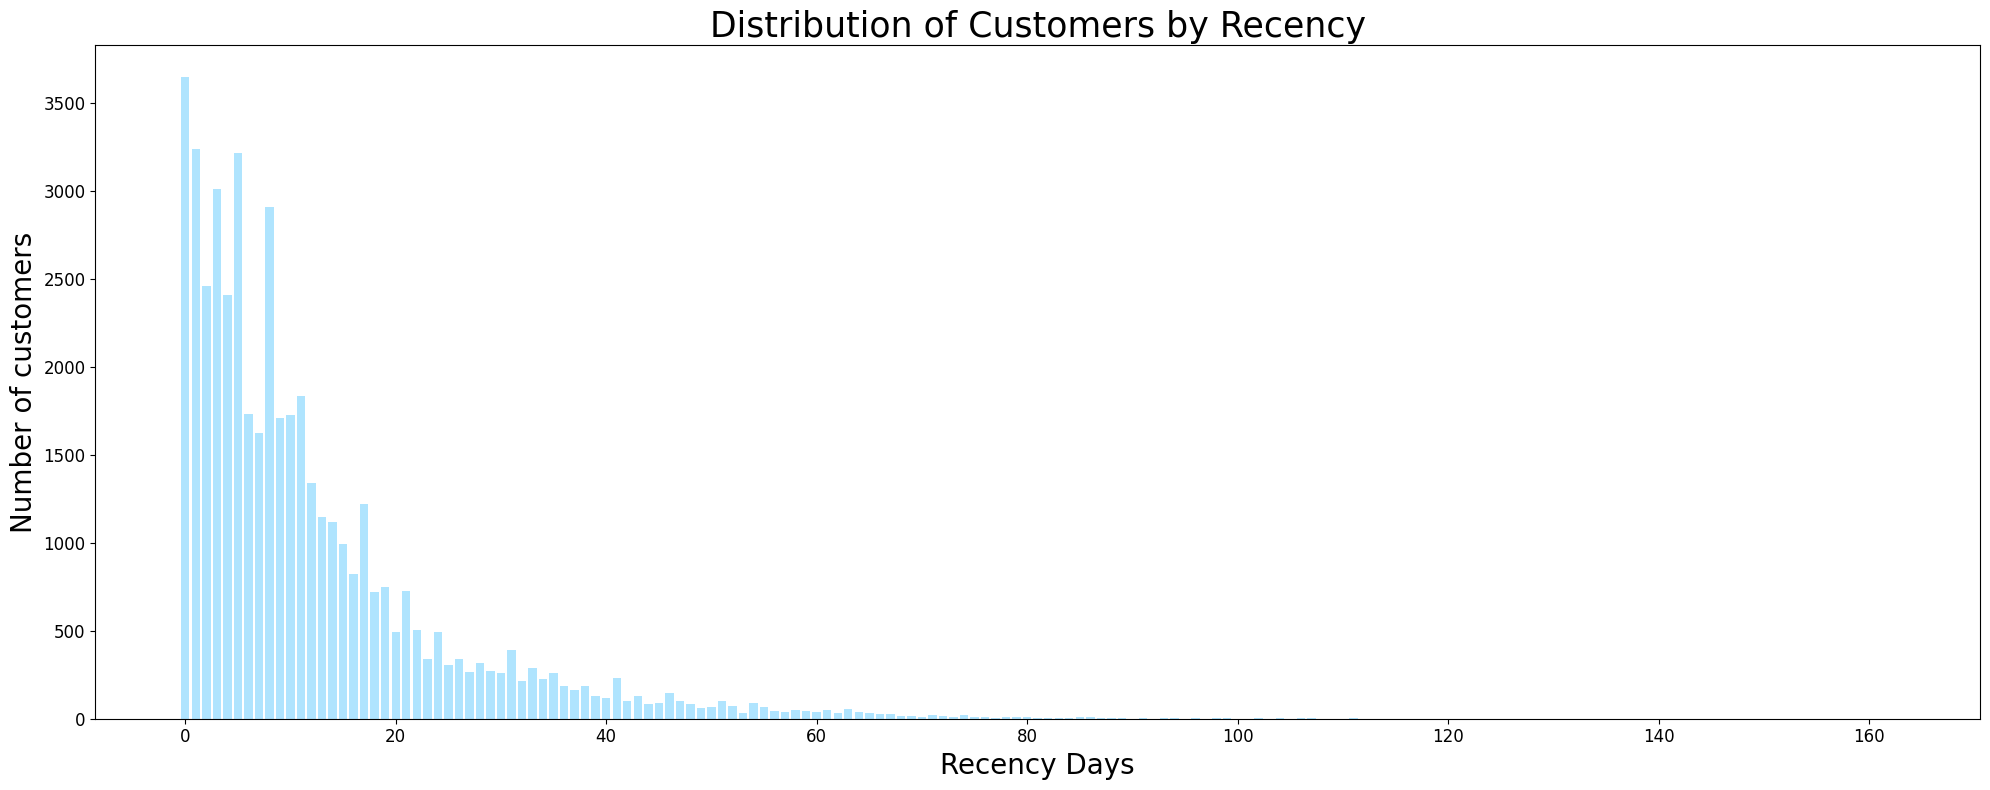

In [59]:
customer_by_recency.sort_values(by='RECENCY_DAYS', ascending=True, inplace=True) # Sort values in ascending order of customer
recency_index = customer_by_recency['RECENCY_DAYS'].tolist()
customer_values = customer_by_recency['NO_OF_CUST'].tolist()

# Create a figure and subplot
fig, V4 = plt.subplots(figsize=(20,8))

# Create a bar chart 
V4.bar(recency_index,customer_values, align = 'center', color='#AFE4FE') # align define the alignment of x-ticks

# Display data labels
#for x,y in zip(recency_index,customer_values):

#    label = x

#    plt.annotate(label, 
#                 (x,y), 
#                 textcoords="offset points", 
#                 xytext=(30,-3), 
#                 fontsize = 10,
#                 ha='center') 

# State title of plot and the axes labels
V4.set_title('Distribution of Customers by Recency', fontsize = 25)
V4.set_ylabel('Number of customers', fontsize = 20)
V4.set_xlabel('Recency Days', fontsize = 20)

# Set font size of ticks on the x-axis and y-axis
V4.tick_params(labelsize = 12, axis ='both')

# Set tight layout for figure
fig.tight_layout()

# Display plot
plt.show()

In [60]:
# Sum of customers where RECENCY_DAYS is below or equal to 30
sum_below_30 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] <= 30]['NO_OF_CUST'].sum()

# Sum of customers where RECENCY_DAYS is more than 30
sum_above_30 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] > 30]['NO_OF_CUST'].sum()

# Print the results
print("Sum of customers where RECENCY_DAYS is below or equal to 30:", sum_below_30)
print("Sum of customers where RECENCY_DAYS is more than 30:", sum_above_30)
print("prob not this cos data of rows relatively less")

Sum of customers where RECENCY_DAYS is below or equal to 30: 41959
Sum of customers where RECENCY_DAYS is more than 30: 4341
prob not this cos data of rows relatively less


In [61]:
# Find recency days based on percentage of customer (20%)

# Sort the DataFrame by RECENCY_DAYS in ascending order
customer_by_recency = customer_by_recency.sort_values('RECENCY_DAYS')

# Calculate the cumulative sum of customer counts
customer_by_recency['CUMULATIVE_COUNT'] = customer_by_recency['NO_OF_CUST'].cumsum()

# Find the RECENCY_DAYS where 80% of the customers are at
target_percentage = 0.8
target_recency_days = None

for index, row in customer_by_recency.iterrows():
    if row['CUMULATIVE_COUNT'] >= target_percentage * customer_by_recency['NO_OF_CUST'].sum():
        target_recency_days = row['RECENCY_DAYS']
        break

# Print the result
print("RECENCY_DAYS where 80% of the customers are at:", target_recency_days)


RECENCY_DAYS where 80% of the customers are at: 19


In [62]:
# Sum of customers where RECENCY_DAYS is below or equal to 18
sum_below_18 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] <= 18]['NO_OF_CUST'].sum()

# Sum of customers where RECENCY_DAYS is more than 18
sum_above_18 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] > 18]['NO_OF_CUST'].sum()

# Print the results
print("Sum of customers where RECENCY_DAYS is below or equal to 18:", sum_below_18)
print("Sum of customers where RECENCY_DAYS is more than 18:", sum_above_18)

Sum of customers where RECENCY_DAYS is below or equal to 18: 36893
Sum of customers where RECENCY_DAYS is more than 18: 9407


In [63]:
# Find recency days based on percentage of customer (30%)

# Sort the DataFrame by RECENCY_DAYS in ascending order
customer_by_recency = customer_by_recency.sort_values('RECENCY_DAYS')

# Calculate the cumulative sum of customer counts
customer_by_recency['CUMULATIVE_COUNT'] = customer_by_recency['NO_OF_CUST'].cumsum()

# Find the RECENCY_DAYS where 70% of the customers are at
target_percentage = 0.7
target_recency_days = None

for index, row in customer_by_recency.iterrows():
    if row['CUMULATIVE_COUNT'] >= target_percentage * customer_by_recency['NO_OF_CUST'].sum():
        target_recency_days = row['RECENCY_DAYS']
        break

# Print the result
print("RECENCY_DAYS where 70% of the customers are at:", target_recency_days)


RECENCY_DAYS where 70% of the customers are at: 14


In [64]:
# Sum of customers where RECENCY_DAYS is below or equal to 13
sum_below_14 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] <= 14]['NO_OF_CUST'].sum()

# Sum of customers where RECENCY_DAYS is more than 13
sum_above_14 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] > 14]['NO_OF_CUST'].sum()

# Print the results
print("Sum of customers where RECENCY_DAYS is below or equal to 14:", sum_below_14)
print("Sum of customers where RECENCY_DAYS is more than 14:", sum_above_14)

Sum of customers where RECENCY_DAYS is below or equal to 14: 33134
Sum of customers where RECENCY_DAYS is more than 14: 13166


### 3.8 Merging of dataframes <a id="part3-8"></a>

In [65]:
customer_final = customer_last_order_timestamp_df1.join(customer_first_order_timestamp_df2, customer_last_order_timestamp_df1.CUSTOMER_ID == customer_first_order_timestamp_df2.CUSTOMER_ID, lsuffix = "", rsuffix = "_ID")
customer_final = customer_final.drop("CUSTOMER_ID_ID", "FIRST_ORDER_TS", "FIRST_TRANS", "LAST_ORDER_TS", "LAST_TRANS")
customer_final.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"DAYS_DF1"  |"DAYS_DF2"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|92902          |123                  |1                    |19.187500            |2449.7500      |3.408219         |718.7771677818    |19.071544             |65             |16              |16          |0           |
|100201         |128                  |1                    |18.485294            |2621.0000      |3.463014         |756.855

### 3.9 Adding Target Variable (Days to next purchase) <a id="part3-9"></a>

In [66]:
customer_final = customer_final.withColumn("TARGET", col("DAYS_DF1")+col("DAYS_DF2"))
customer_final = customer_final.drop("DAYS_DF1", "DAYS_DF2")
customer_final.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"TARGET"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|41644          |270                  |1                    |31.222222            |1520.0000      |3.169863         |479.5159917006    |11.672429             |37             |33              |42        |
|105132         |270                  |3                    |29.261905            |1891.0000      |3.446575         |548.6606268542    |12.476154             |43             |29       

### 3.10 Scaling <a id="part3-10"></a>

In [67]:
customer_final = customer_final.to_pandas()

# save dataframe of customer_id 
customer_id_df = customer_final["CUSTOMER_ID"]

customer_final = customer_final.drop(["CUSTOMER_ID"],  axis = 1)
#customer_final = customer_final.drop(["CUSTOMER_ID", 'CITY_FREQUENCY', 'GENDER', 'MARITAL_STATUS', 'CHILDREN_COUNT'],  axis = 1)

customer_final.head()

,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,TARGET
0,68,1,19.940000,1934.00,2.736986,706.6166944223,18.633636,51,2,4
1,106,1,19.509091,1773.75,2.989041,593.4177550592,18.735106,56,18,21
2,83,1,17.790323,2607.50,3.049315,855.1100821004,20.660378,63,10,13
3,57,1,19.480769,2161.00,2.832877,762.8287426528,18.708896,53,21,27
4,72,1,14.567164,2339.50,2.736986,854.7723663914,24.844848,68,23,26


In [68]:
#drop target
target = customer_final['TARGET']
customer_final.drop('TARGET', axis = 1, inplace = True)

scaler = StandardScaler()
scaler.fit(customer_final)

final_scaled = scaler.transform(customer_final)
final_scaled = pd.DataFrame(final_scaled, columns=customer_final.columns)

#assign target variable back to scaled data frame
final_scaled = final_scaled.assign(TARGET = target)

final_scaled.head()

,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,TARGET
0,-0.857842,-0.247799,-0.223871,-0.297898,-0.699964,-0.015485,0.064053,-0.267809,-0.768372,4
1,-0.284082,-0.247799,-0.293083,-0.631541,0.066043,-0.653371,0.089136,0.215052,0.469642,21
2,-0.631358,-0.247799,-0.569146,1.104338,0.249219,0.821288,0.565066,0.891057,-0.149365,13
3,-1.023931,-0.247799,-0.297632,0.174719,-0.408547,0.301275,0.082657,-0.074665,0.701769,27
4,-0.797447,-0.247799,-1.086839,0.546358,-0.699964,0.819385,1.599471,1.373918,0.856521,26


### 4. Building of models <a id="part4"></a>

#### 4.1 Train Test Split <a id="part4-1"></a>

In [ ]:
# Define ratio for model 
train_ratio = 0.70
test_ratio = 0.20
holdout_ratio = 0.10

# Define Model Inputs (X) and Output (y)
X = final_scaled.drop('TARGET',axis=1)
y = final_scaled["TARGET"]

# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_ratio, random_state=1)
X_holdout, X_test, y_holdout, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + holdout_ratio)) 

#### 4.2 Linear Regression Model <a id="part4-2"></a>

In [ ]:
# Create the model "lg"
lg = LinearRegression()
lg.fit(X_train, y_train)

#MSE

train_mse = mean_squared_error(lg.predict(X_train), y_train)
print('The Training Mean Squared Error for Linear Regression Model is: ', train_mse)
test_mse = mean_squared_error(lg.predict(X_test), y_test)
print('The Testing Mean Squared Error for Linear Regression Model is: ',test_mse)

print('')

#R^2

train_R2 = lg.score(X_train, y_train)
print('The Training R^2 for Linear Regression Model is: ', train_R2)

test_R2 = lg.score(X_test, y_test)
print('The Testing R^2 for Linear Regression Model is: ', test_R2)

In [ ]:
##### holdout model

# Create the model "lg"
lg = LinearRegression()
lg.fit(X_holdout, y_holdout)


#MSE

holdout_mse = mean_squared_error(lg.predict(X_holdout), y_holdout)
print('The Holdout Mean Squared Error for Linear Regression Model is: ', holdout_mse)

print('')

#R^2

holdout_R2 = lg.score(X_holdout, y_holdout)
print('The Holdout R^2 for Linear Regression Model is: ', holdout_R2)

#### 4.3 Decision Tree Model <a id="part4-3"></a>

In [ ]:
dt = tree.DecisionTreeRegressor(max_depth=2, random_state=1)
dt.fit(X_train, y_train)

#MSE

train_mse = mean_squared_error(dt.predict(X_train), y_train)
print('The Training Mean Squared Error for Decision Tree Regressor Model is: ', train_mse)
test_mse = mean_squared_error(dt.predict(X_test), y_test)
print('The Testing Mean Squared Error for Decision Tree Regressor Model is: ',test_mse)

print('')

#R^2

train_R2 = dt.score(X_train, y_train)
print('The Training R^2 for Decision Tree Regressor Model is: ', train_R2)

test_R2 = dt.score(X_test, y_test)
print('The Testing R^2 for Decision Tree Regressor is: ', test_R2)

In [ ]:
# Computing feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['feature']), 
           pd.DataFrame(dt.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

#### 4.4 Random Forest Model <a id="part4-4"></a>

In [ ]:
# Create Random Forest Model
rf = RandomForestRegressor(max_depth=2, random_state=1, n_estimators=20)
# Y_train is a 1D array, use ravel() to change the shape of Y_train to (n_samples,) before feed it into fit function
rf.fit(X_train, y_train.ravel())

#MSE

train_mse = mean_squared_error(rf.predict(X_train), y_train)
print('The Training Mean Squared Error for Random Forest Regressor Model is: ', train_mse)
test_mse = mean_squared_error(rf.predict(X_test), y_test)
print('The Testing Mean Squared Error for Random Forest Regressor Model is: ',test_mse)

print('')

#R^2

train_R2 = rf.score(X_train, y_train)
print('The Training R^2 for Random Forest Regressor Model is: ', train_R2)

test_R2 = rf.score(X_test, y_test)
print('The Testing R^2 for Random Forest Regressor Model is: ', test_R2)

#### 4.5 ANN Model <a id="part4-5"></a>

In [ ]:
# Create the ann model
mlp = MLPClassifier(activation ='logistic', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=1)
# Fit the model to the training set
mlp.fit(X_train,y_train)

#MSE

train_mse = mean_squared_error(mlp.predict(X_train), y_train)
print('The Training Mean Squared Error for ANN Model is: ', train_mse)
test_mse = mean_squared_error(mlp.predict(X_test), y_test)
print('The Testing Mean Squared Error for ANN Model is: ',test_mse)

print('')

#R^2

train_R2 = mlp.score(X_train, y_train)
print('The Training R^2 for ANN Model is: ', train_R2)

test_R2 = mlp.score(X_test, y_test)
print('The Testing R^2 for ANN Model is: ', test_R2)

#### 4.6 SVM Model <a id="part4-6"></a>

In [ ]:
# Create the SVM model
svm = SVR()
svm.fit(X_train, y_train)

#MSE

train_mse = mean_squared_error(svm.predict(X_train), y_train)
print('The Training Mean Squared Error for SVM Model is: ', train_mse)
test_mse = mean_squared_error(svm.predict(X_test), y_test)
print('The Testing Mean Squared Error for SVM Model is: ',test_mse)

print('')

#R^2

train_R2 = svm.score(X_train, y_train)
print('The Training R^2 for SVM Model is: ', train_R2)

test_R2 = svm.score(X_test, y_test)
print('The Testing R^2 for SVM Model is: ', test_R2)